## 3 - Etapa de processamento dos dados

Nesta etapa faremos o **tratamento dos dados**, **seleção de variáveis**, **seleção de algoritmos**, **seleção de modelos de aprendizagem**, **seleção de métricas de avaliação** e aplicaremos técnicas de amostragem para estabelecer a divisão dos **dados de treino** e **dados de teste** dos algoritmos.

In [1]:
## Pacotes utilizados 

import pandas as pd 
import numpy as np 
import seaborn as sea
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Normalização 
from sklearn.preprocessing import MinMaxScaler
## Padronização 
from sklearn.preprocessing import StandardScaler

# Divisão treino/teste 
from sklearn.model_selection import train_test_split

# Métricas 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# Algoritmos de aprendizagem 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Otimização 
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

#### Dados resultantes do processo de análise e pré preparação. 

In [2]:
df_treino = pd.read_csv('dados/df_treino.csv')
df_teste = pd.read_csv('dados/df_teste.csv')

#### Codificação numérica das variáveis do tipo object

Note que algumas das variáveis qualitativas são do tipo "object", ou seja, texto. Esse tipo de informação não pode ser apresentada aos algoritmos de aprendizado de máquina, logo devemos altera-lá para números discretos. Essa transformação pode parecer muito abstrata, então utilizaremos um exemplo para mostrar como ela funciona:

In [3]:
# Exemplo utilizando a função get_dummies() do pandas. 
# Utilizaremos apenas duas variáveis para exemplificar. 

df_exemplo = df_treino[['MSZoning','Street']]
print("Categorias na variável 'MSZoning': ", pd.unique(df_exemplo['MSZoning']))
print("Categorias na variável 'Street': ", pd.unique(df_exemplo['Street']))
df_exemplo

Categorias na variável 'MSZoning':  ['FV' 'RL' 'RM' 'RH' 'C (all)']
Categorias na variável 'Street':  ['Pave' 'Grvl']


,MSZoning,Street
0,FV,Pave
1,RL,Pave
2,RL,Pave
3,RL,Pave
4,RL,Pave
...,...,...
931,RL,Pave
932,RL,Pave
933,RM,Pave
934,RL,Pave


In [4]:
# Ao utilizar a função get_dummies no dataframe da celula anterior perceba que cada uma das categorias se tornou uma coluna. 
# Houve uma expansão da quantidade de dados, mas a informação representada é a mesma, mas agora de forma numérica. 

df_exemplo = pd.get_dummies(df_exemplo, drop_first = False)
df_exemplo.head()

# Fim do exemplo. 

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave
0,0,1,0,0,0,0,1
1,0,0,0,1,0,0,1
2,0,0,0,1,0,0,1
3,0,0,0,1,0,0,1
4,0,0,0,1,0,0,1


Utilizando a técnica demonstrada no exemplo, transformaremos todas variáveis qualitativas com dados em texto, presentes no dataframe, em variáveis qualitativas representadas por **valores discretos**.

Juntando os dois dataframes para codificação numérica ( esta etapa pode ser realizada em conjunto sem risco de perda de generalização)

In [5]:
df = pd.concat([df_treino, df_teste])
df.shape

(1338, 75)

In [6]:
df_cod = df.copy()
df_cod = pd.get_dummies(df_cod, drop_first = False)
df_cod.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,75.000000,9803,7,5,2005,2005,0.0,400,0,...,0,0,0,1,0,0,0,0,1,0
1,50,60.000000,9084,5,6,1941,1950,0.0,236,380,...,1,0,0,0,0,0,0,0,1,0
2,20,64.000000,6762,7,5,2007,2007,108.0,664,0,...,0,1,0,0,0,0,0,0,0,1
3,85,70.116745,12122,7,9,1961,2007,210.0,867,0,...,0,0,0,1,0,0,0,0,1,0
4,190,60.000000,10800,5,4,1900,1970,0.0,664,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
df_cod.shape

(1338, 266)

In [8]:
# Colacando a variável alvo na última coluna.

alvo = df_cod['SalePrice']
del df_cod['SalePrice'] 
df_cod['SalePrice'] = alvo 

### 3.1) Tratamento dos dados 

#### Tratando outliers 

Os outliers serão analisados visualmente e os pontos considerados extremos serão eliminados. Após a remoção uma nova inspeção visual será realizada.

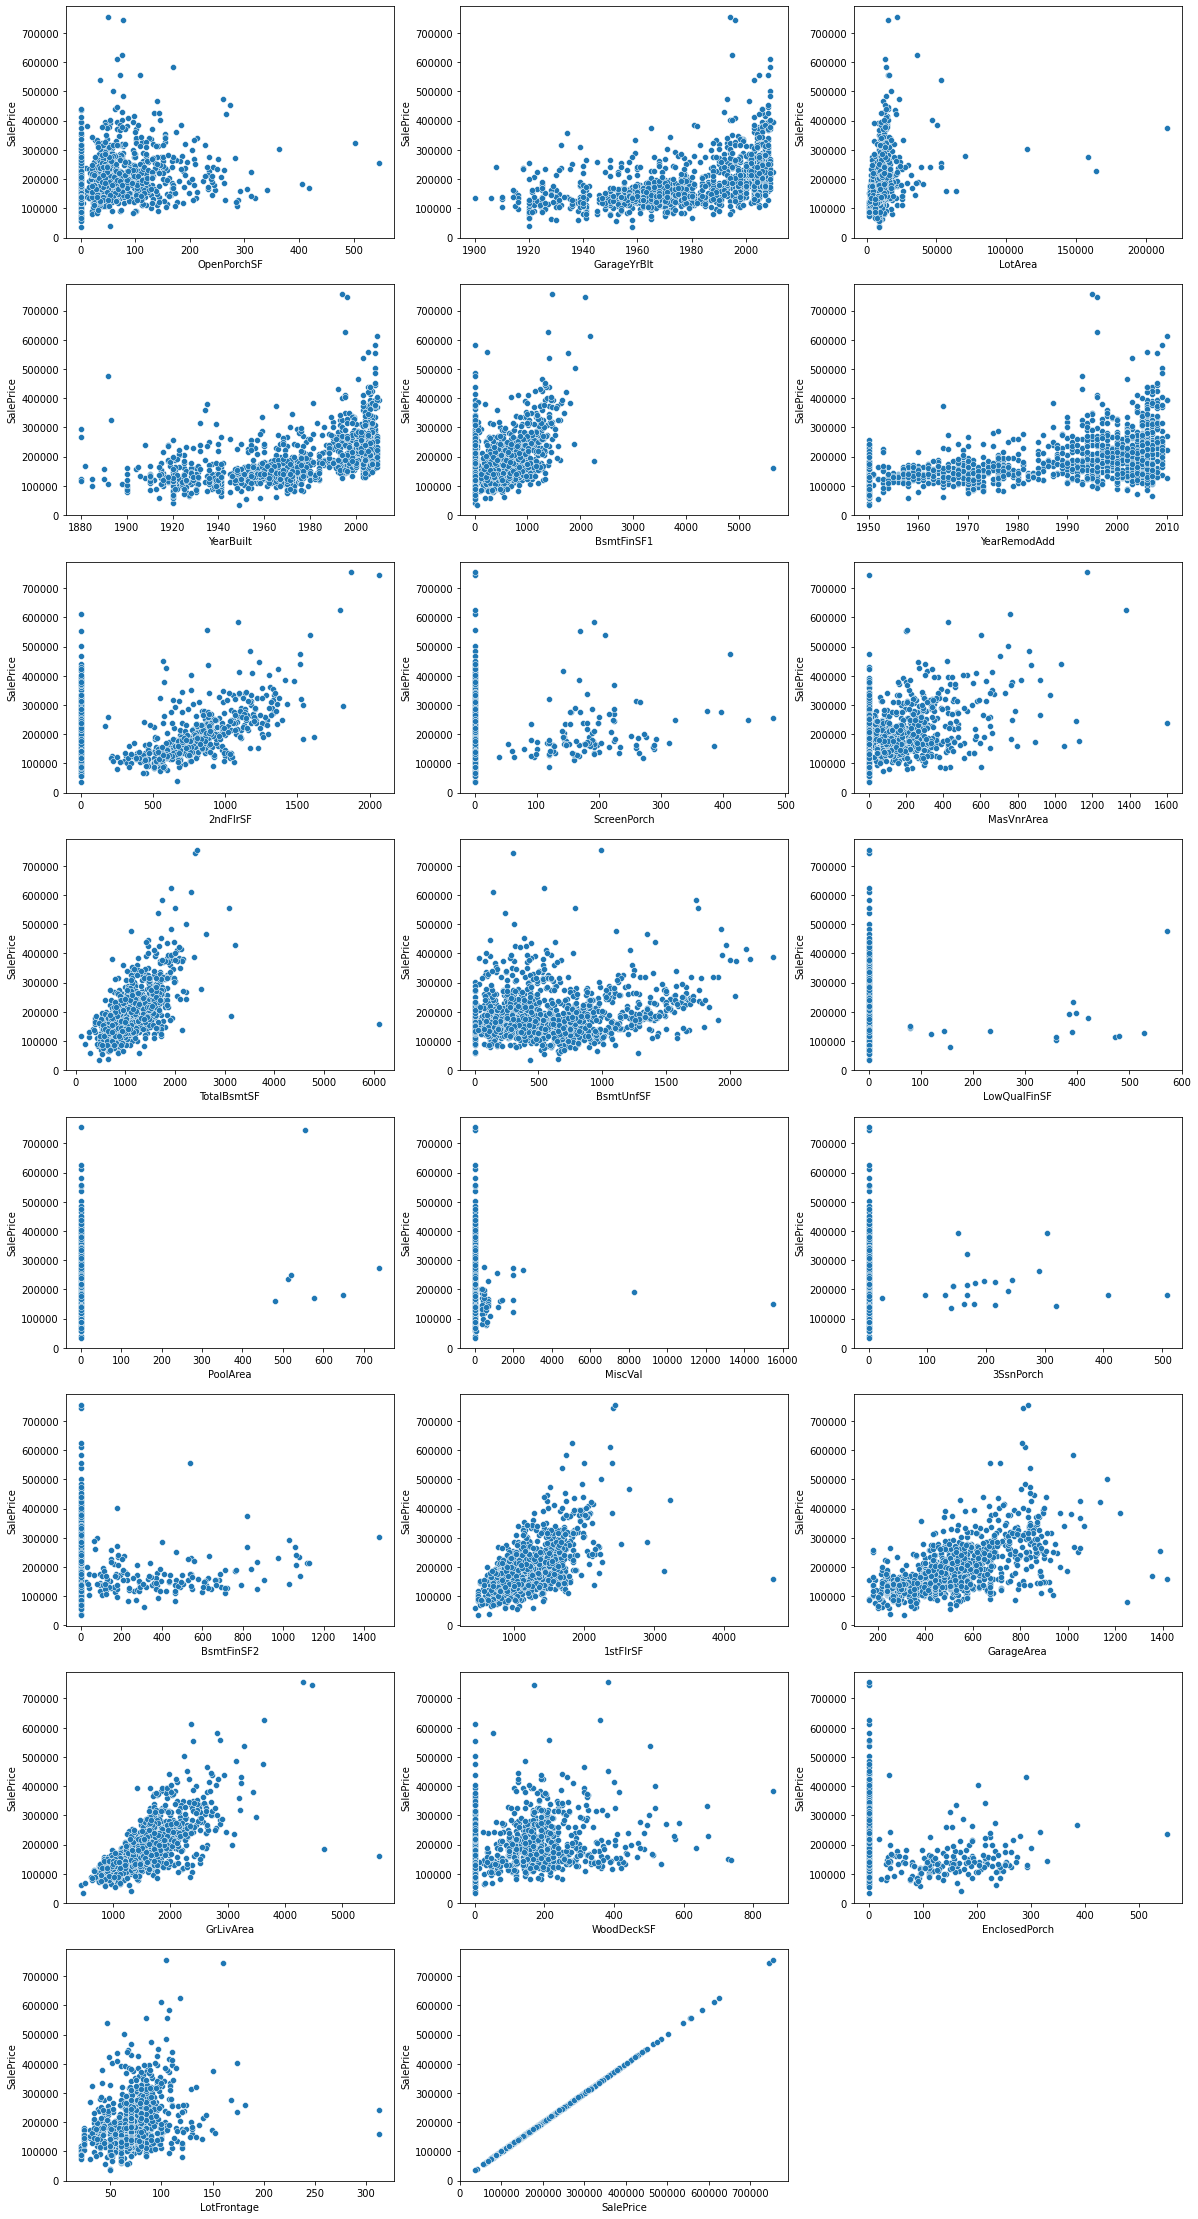

In [9]:
# Lista de variáveis quantitativas 
qt = ['OpenPorchSF', 'GarageYrBlt', 'LotArea', 'YearBuilt', 'BsmtFinSF1', 'YearRemodAdd', '2ndFlrSF', 'ScreenPorch',
      'MasVnrArea', 'TotalBsmtSF', 'BsmtUnfSF', 'LowQualFinSF', 'PoolArea', 'MiscVal', '3SsnPorch', 'BsmtFinSF2', '1stFlrSF',
      'GarageArea', 'GrLivArea', 'WoodDeckSF', 'EnclosedPorch', 'LotFrontage','SalePrice']

plt.figure(figsize = (20,40))
x = 1

for variavel in df_cod[qt]:
    plt.subplot(8, 3, x)
    sea.scatterplot(data = df_cod[qt], x = variavel, y = 'SalePrice')
    x += 1

In [10]:
# Eliminando os outliers 

df_trat = df_cod

df_trat = df_trat.drop(df_trat['BsmtUnfSF'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['BsmtFinSF1'].sort_values(ascending = False)[:1].index)
df_trat = df_trat.drop(df_trat['PoolArea'].sort_values(ascending = False)[:1].index)
df_trat = df_trat.drop(df_trat['MiscVal'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['1stFlrSF'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['ScreenPorch'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['WoodDeckSF'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['TotalBsmtSF'].sort_values(ascending = False)[:1].index)
df_trat = df_trat.drop(df_trat['GarageArea'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['GrLivArea'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['2ndFlrSF'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['LotArea'].sort_values(ascending = False)[:4].index)
df_trat = df_trat.drop(df_trat['BsmtFinSF2'].sort_values(ascending = False)[:1].index)
df_trat = df_trat.drop(df_trat['LowQualFinSF'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['3SsnPorch'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['LotFrontage'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['EnclosedPorch'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['MasVnrArea'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['OpenPorchSF'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['SalePrice'].sort_values(ascending = False)[:3].index)

df_trat.shape

(1270, 266)

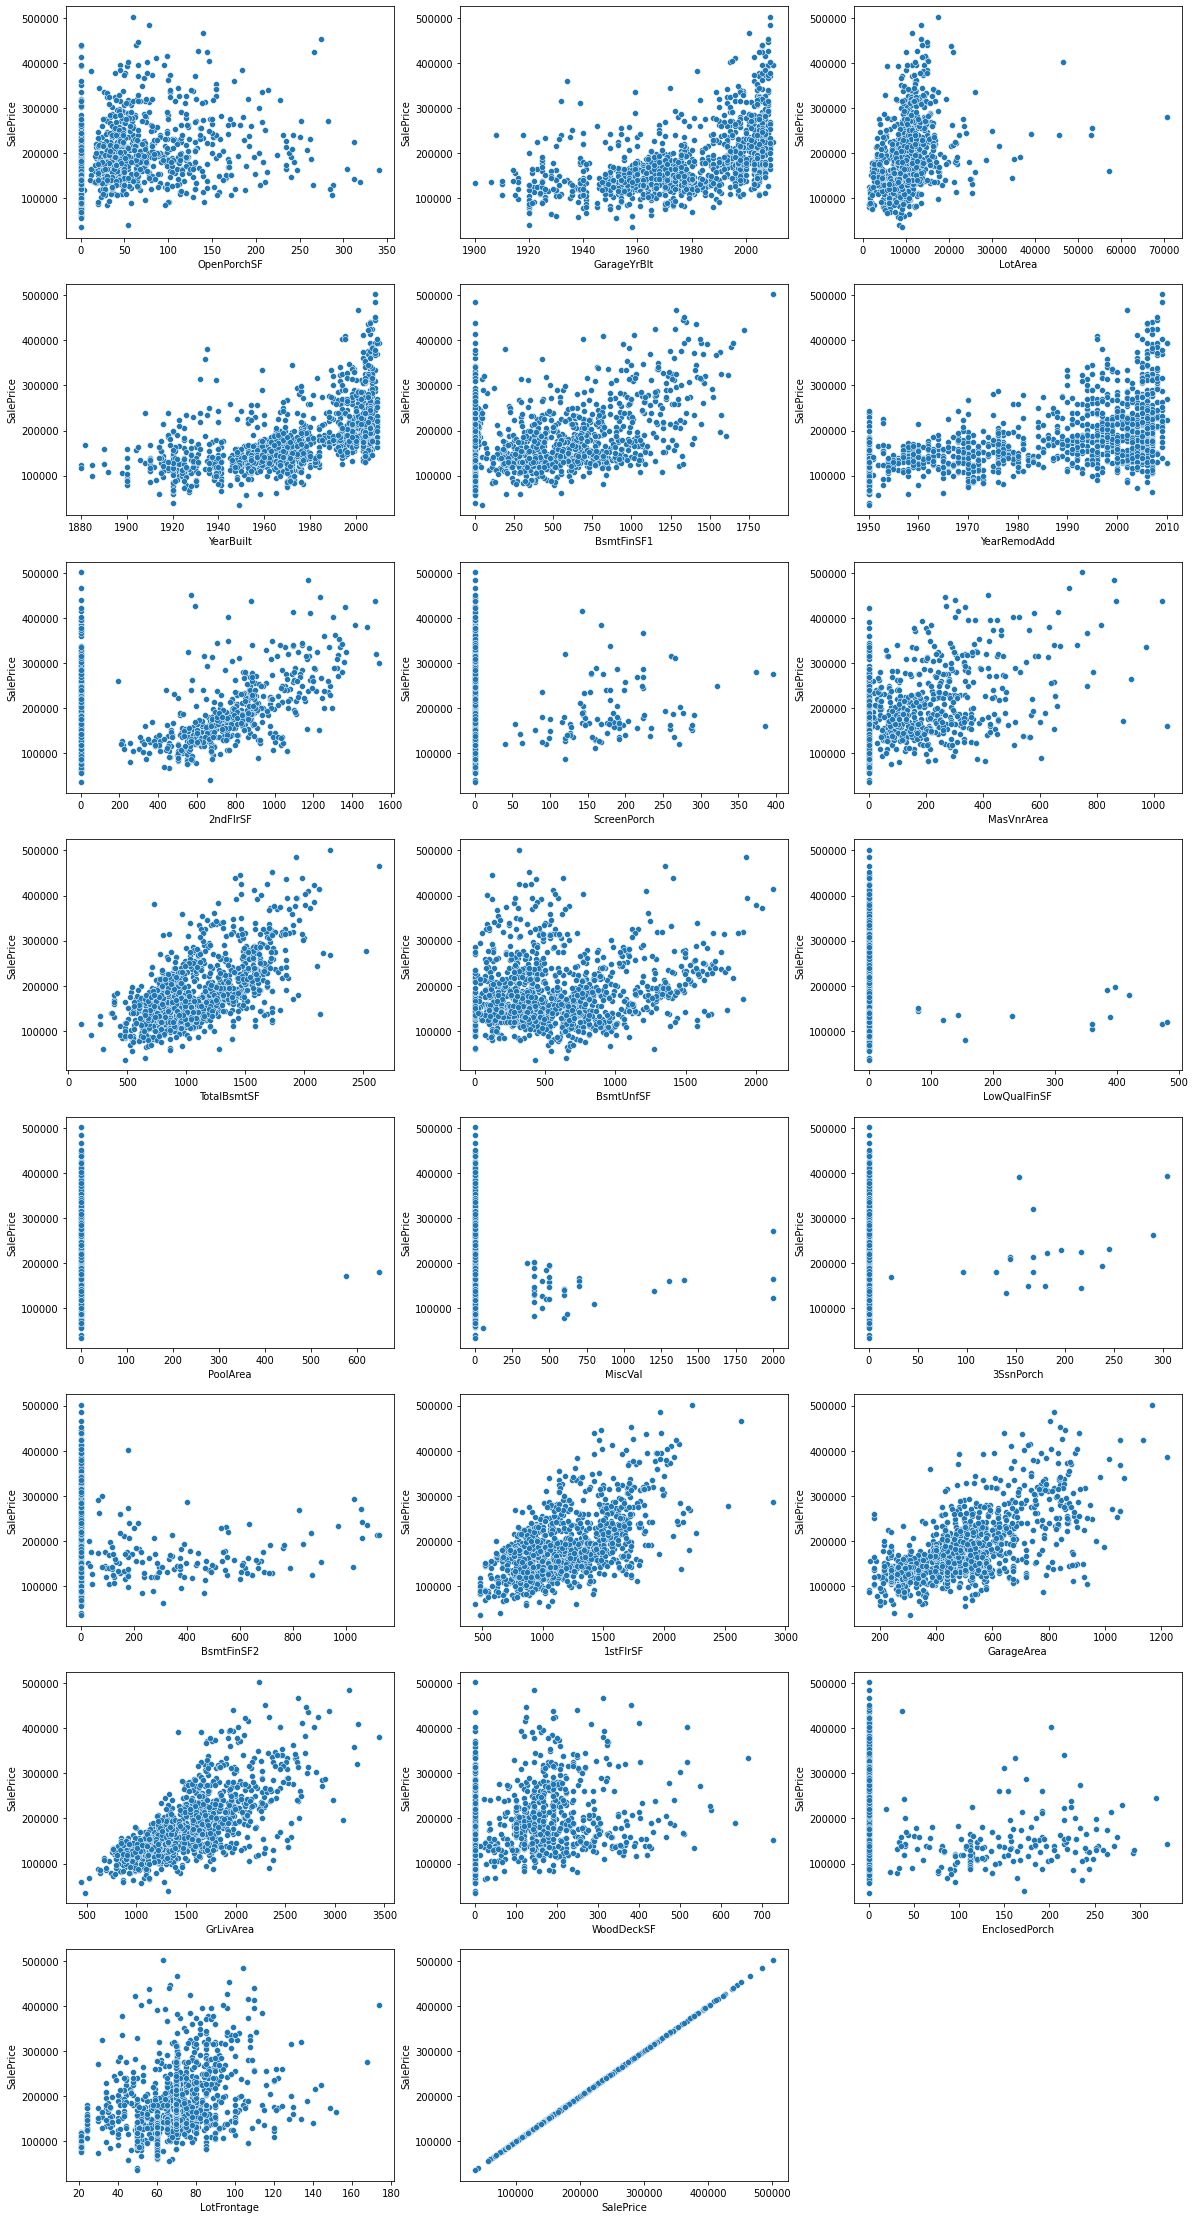

In [11]:
# Analisando novamente

plt.figure(figsize = (20,40))
x = 1
for variavel in df_trat[qt].columns:
    plt.subplot(8, 3, x)
    sea.scatterplot(data = df_trat[qt], x = variavel, y = 'SalePrice')
    x += 1

#### Tratando a forma 

Iremos aplicar uma **tranformação de log(x + 1)**  para tornar a distribuição dos dados mais próximas de uma distribuição normal. 

In [12]:
# Dataframe obtido após a remoção dos outliers. 

df_trat.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,60,75.000000,9803,7,5,2005,2005,0.0,400,0,...,0,0,1,0,0,0,0,1,0,226700
1,50,60.000000,9084,5,6,1941,1950,0.0,236,380,...,0,0,0,0,0,0,0,1,0,95000
3,85,70.116745,12122,7,9,1961,2007,210.0,867,0,...,0,0,1,0,0,0,0,1,0,178400
4,190,60.000000,10800,5,4,1900,1970,0.0,664,0,...,0,0,0,0,0,0,0,1,0,160000
5,20,55.000000,8250,5,5,1968,1968,0.0,250,492,...,0,0,1,0,0,0,0,1,0,134000


In [13]:
# Dataframe obtido após a transformação de log(x+1).

df_trat_log = df_trat.copy()
df_trat_log[qt] = np.log1p(df_trat_log[qt])
df_trat_log.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,60,4.330733,9.190546,7,5,7.603898,7.603898,0.000000,5.993961,0.000000,...,0,0,1,0,0,0,0,1,0,12.331387
1,50,4.110874,9.114380,5,6,7.571474,7.576097,0.000000,5.468060,5.942799,...,0,0,0,0,0,0,0,1,0,11.461643
3,85,4.264323,9.402860,7,9,7.581720,7.604894,5.351858,6.766192,0.000000,...,0,0,1,0,0,0,0,1,0,12.091789
4,190,4.110874,9.287394,5,4,7.550135,7.586296,0.000000,6.499787,0.000000,...,0,0,0,0,0,0,0,1,0,11.982935
5,20,4.025352,9.018090,5,5,7.585281,7.585281,0.000000,5.525453,6.200509,...,0,0,1,0,0,0,0,1,0,11.805603


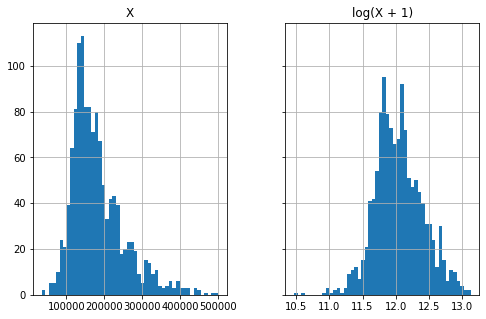

In [14]:
# Exemplo para ilustrar o tratamento de forma. 

x = {"X":df_trat["SalePrice"], "log(X + 1)":np.log1p(df_trat["SalePrice"])}
dados = pd.DataFrame(x)
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
dados.hist(sharex = False, sharey = True, bins = 50)
plt.show()

### 3.2) Seleção de métricas

#### Métricas utilizadas

Para avaliação de todos os modelos utilizaremos as três métricas descritas abaixo, um modelo que tiver avaliações melhores em **duas ou mais** métricas será o escolhido, em todas as comparações realizadas. 

**R²**: calcula qual a porcentagem da variância que pode ser prevista pelo modelo, por exemplo, R² = XX significa que XX% da variância dos dados pode ser explicada pelo modelo. Essa métrica varia de 0 a 100 e quanto **mais próximo de 100%**, **melhor** é o modelo. 

**MAPE**: exprime uma porcentagem, significando que, em média, o modelo faz previsões que erram por XX% do valor real, ou seja, quanto **menor o MAPE**, **melhor** é o modelo. 

**RMSE**: métrica utilizada como uma forma de melhorar a interpretabilidade do erro, pois nela o erro será expresso em unidades da variável alvo, assim quanto **menor o RMSE**, **melhor** é o modelo.  

In [15]:
# Funções para aplicar as métricas 

def metricas(y_teste, y_pred):
    rmse = (mean_squared_error(y_teste, y_pred))**(1/2)
    print("R² = %.2f %%" % (r2_score(y_teste, y_pred)*100))
    print("MAPE = %.2f %% " % (mean_absolute_percentage_error(y_teste, y_pred)*100))
    print("RMSE = %.2f USD" % (rmse)) 
    
def valores_metricas(y_teste, y_pred):
    r2 = (r2_score(y_teste, y_pred)*100)
    mape = (mean_absolute_percentage_error(y_teste, y_pred)*100)
    rmse = (mean_squared_error(y_teste, y_pred))**(1/2)
    return [r2, mape, rmse]

### 3.3) Seleção de algoritmo de aprendizagem

#### 3.3.1) Divisão dados de treino e teste. 

In [16]:
# Dados pré processados - sem valores missing e sem tratamento de outliers 
X_cod = df_cod.iloc[:,:-1]
Y_cod = df_cod['SalePrice']
x_treino_cod, x_teste_cod, y_treino_cod, y_teste_cod = train_test_split(X_cod, 
                                                                        Y_cod, 
                                                                        test_size = 0.30, 
                                                                        random_state = 5)

# Dados tratados - sem valores missing e com tratamento de outliers 
X_trat = df_trat.iloc[:,:-1]
Y_trat = df_trat['SalePrice']
x_treino_trat, x_teste_trat, y_treino_trat, y_teste_trat = train_test_split(X_trat, 
                                                                            Y_trat, 
                                                                            test_size = 0.30, 
                                                                            random_state = 5)

# Dados tratados - sem valores missing, com tratamento de outliers e transformação de log.
X_trat_log = df_trat_log.iloc[:,:-1]
Y_trat_log = df_trat['SalePrice']
x_treino_trat_log, x_teste_trat_log, y_treino_trat_log, y_teste_trat_log = train_test_split(X_trat_log, 
                                                                                            Y_trat_log, 
                                                                                            test_size = 0.30, 
                                                                                            random_state = 5)

#### Modelo base 

In [17]:
def modelo_base(x_treino, x_teste, y_treino, y_teste):
    modelo_base = LinearRegression(normalize = False).fit(x_treino, y_treino)
    print("Métricas de treino do modelo_base:")
    metricas(y_treino, modelo_base.predict(x_treino))
    print("-------------------")
    print("Métricas de teste do modelo_base:")
    metricas(y_teste, modelo_base.predict(x_teste))

O **modelo base** utilizará o algoritmo de **regressão linear multivariada** e o conjunto de dados sem nenhum tipo de tratamento de forma, outliers ou seleção de variáveis, ou seja, será treinado com o **dataframe pré-processado** ( apenas sem os valores missing e com codificação numérica das variáveis categóricas).

In [18]:
modelo_base(x_treino_cod, x_teste_cod, y_treino_cod, y_teste_cod)

Métricas de treino do modelo_base:
R² = 94.74 %
MAPE = 7.20 % 
RMSE = 18539.03 USD
-------------------
Métricas de teste do modelo_base:
R² = 50.43 %
MAPE = 12.72 % 
RMSE = 52204.53 USD


#### Modelo base treinado com os dados sem outilers

In [19]:
modelo_base(x_treino_trat, x_teste_trat, y_treino_trat, y_teste_trat)

Métricas de treino do modelo_base:
R² = 94.98 %
MAPE = 6.38 % 
RMSE = 15605.77 USD
-------------------
Métricas de teste do modelo_base:
R² = 89.41 %
MAPE = 9.95 % 
RMSE = 22941.02 USD


#### Modelo base treinado com dados sem outliers + tranformação de log

In [20]:
modelo_base(x_treino_trat_log, x_teste_trat_log, y_treino_trat_log, y_teste_trat_log)

Métricas de treino do modelo_base:
R² = 93.97 %
MAPE = 7.08 % 
RMSE = 17102.15 USD
-------------------
Métricas de teste do modelo_base:
R² = 88.01 %
MAPE = 10.67 % 
RMSE = 24406.05 USD


#### Seleção de algoritmo

Função utilizada para treinar diversos algoritmos de regressão e retornar uma tabela indicando o valor das métricas de avaliação para cada algoritmo. 

In [21]:
def selec_model(x_treino, x_teste, y_treino, y_teste):

    modelos = []
    modelos.append(('LinReg', LinearRegression()))
    modelos.append(('LASSO', Lasso()))
    modelos.append(('RIDGE', Ridge()))
    modelos.append(('ELASTIC', ElasticNet()))
    modelos.append(('KNN_R', KNeighborsRegressor()))
    modelos.append(('CART', DecisionTreeRegressor()))
    modelos.append(('SVR', SVR()))

    resultados = {}
    for nome, modelo in modelos:
        model = modelo.fit(x_treino, y_treino)
        y_pred = model.predict(x_teste)
        resultados[nome] = valores_metricas(y_teste, y_pred)

    df_result = pd.DataFrame(resultados, index = ['R² (%)','MAPE (%)','RMSE (USD)'])
    return df_result.round(2)

In [22]:
selec_model(x_treino_trat, x_teste_trat, y_treino_trat, y_teste_trat)

,LinReg,LASSO,RIDGE,ELASTIC,KNN_R,CART,SVR
R² (%),89.41,89.53,90.70,88.73,65.82,75.75,-7.30
MAPE (%),9.95,9.88,9.22,9.95,15.62,14.00,27.88
RMSE (USD),22941.02,22811.78,21491.96,23659.99,41209.40,34708.47,73016.20


In [23]:
selec_model(x_treino_trat_log, x_teste_trat_log, y_treino_trat_log, y_teste_trat_log)

,LinReg,LASSO,RIDGE,ELASTIC,KNN_R,CART,SVR
R² (%),88.01,88.09,89.57,84.91,71.68,72.86,-7.34
MAPE (%),10.67,10.59,9.80,10.49,15.29,14.17,27.89
RMSE (USD),24406.05,24326.94,22767.44,27377.35,37511.48,36724.80,73027.76


Com base nos resultados acima, utilizaremos apenas os dados **com tratamento de outliers** e **sem a transformação de log**, pois o resultados para o primeiro se mostraram melhores.

#### Normalizando e/ou Padronizando.

In [24]:
# Apenas NORMALIZAÇÃO 
def norm(x):
    return MinMaxScaler().fit_transform(x)

# Apenas PADRONIZAÇÃO 
def pad(x):
    return StandardScaler().fit_transform(x)

# NORMALIZAÇÃO e PADRONIZAÇÃO
def norm_pad(x):
    x = norm(x)
    return pad(x)

# PADRONIZAÇÃO e NORMALIZAÇÃO  
def pad_norm(x):
    x = pad(x)
    return norm(x)

In [25]:
selec_model(norm(x_treino_trat), norm(x_teste_trat), y_treino_trat, y_teste_trat)

,LinReg,LASSO,RIDGE,ELASTIC,KNN_R,CART,SVR
R² (%),-1.076597e+23,87.86,85.81,71.77,77.29,71.62,-7.25
MAPE (%),1.415553e+12,11.20,13.59,15.35,14.01,16.42,27.88
RMSE (USD),2.312818e+15,24558.06,26547.98,37452.73,33587.42,37550.88,72996.96


In [26]:
selec_model(pad(x_treino_trat), pad(x_teste_trat), y_treino_trat, y_teste_trat)

,LinReg,LASSO,RIDGE,ELASTIC,KNN_R,CART,SVR
R² (%),-1.481667e+22,89.95,89.88,91.24,76.27,72.42,-7.28
MAPE (%),3.589046e+11,9.65,9.79,8.10,13.35,14.89,27.88
RMSE (USD),8.580060e+14,22349.95,22419.46,20864.24,34334.76,37020.75,73010.22


In [27]:
selec_model(norm_pad(x_treino_trat), norm_pad(x_teste_trat), y_treino_trat, y_teste_trat)

,LinReg,LASSO,RIDGE,ELASTIC,KNN_R,CART,SVR
R² (%),-1.984746e+22,89.95,89.88,91.24,76.27,75.29,-7.28
MAPE (%),3.738487e+11,9.65,9.79,8.10,13.35,14.32,27.88
RMSE (USD),9.930418e+14,22349.95,22419.46,20864.24,34334.76,35038.27,73010.22


In [28]:
selec_model(pad_norm(x_treino_trat), pad_norm(x_teste_trat), y_treino_trat, y_teste_trat)

,LinReg,LASSO,RIDGE,ELASTIC,KNN_R,CART,SVR
R² (%),-7.850246e+22,87.86,85.81,71.77,77.29,68.43,-7.25
MAPE (%),1.158362e+12,11.20,13.59,15.35,14.01,16.81,27.88
RMSE (USD),1.974952e+15,24558.06,26547.98,37452.73,33587.42,39602.09,72996.96


Os algoritmos **ELASTIC**, **LASSO**  e **RIDGE** foram, respectivamente, os que apresentaram um modelo de melhor desempenho, para os dados com tratamento de outliers e **padronizados**. 

In [29]:
def selec_model2(X, Y, p_treino, random = 5):
    
    x_treino, x_teste, y_treino, y_teste = train_test_split(
    X, Y, train_size = p_treino, random_state = random)
    
    def pad(x):
        return StandardScaler().fit_transform(x)
    
    x_treino = pad(x_treino)
    x_teste = pad(x_teste)

    modelos = []
    modelos.append(('ELASTIC', ElasticNet()))
    modelos.append(('LASSO', Lasso()))
    modelos.append(('RIDGE', Ridge()))

    resultados = {}
    for nome, modelo in modelos:
        model = modelo.fit(x_treino, y_treino)
        y_pred = model.predict(x_teste)
        resultados[nome] = valores_metricas(y_teste, y_pred)

    df_result = pd.DataFrame(resultados, index = ['R² (%)','MAPE (%)','RMSE (USD)'])
    return df_result.round(2)

In [30]:
X_trat = df_trat.iloc[:,:-1]
Y_trat = df_trat['SalePrice']

for p in np.arange(0.5, 0.80, 0.1):
    print('p_treino =',p)
    print(selec_model2(X_trat, Y_trat, p , random = 5))

p_treino = 0.5
             ELASTIC     LASSO     RIDGE
R² (%)         90.65     89.54     89.64
MAPE (%)        8.24      9.91      9.85
RMSE (USD)  21677.15  22927.72  22821.84
p_treino = 0.6
             ELASTIC     LASSO     RIDGE
R² (%)         90.64     88.67     88.65
MAPE (%)        8.23     10.19     10.24
RMSE (USD)  21749.72  23932.34  23947.48
p_treino = 0.7
             ELASTIC     LASSO     RIDGE
R² (%)         91.24     89.95     89.88
MAPE (%)        8.10      9.65      9.79
RMSE (USD)  20864.24  22349.95  22419.46
p_treino = 0.7999999999999999
             ELASTIC     LASSO     RIDGE
R² (%)         93.20     93.04     92.94
MAPE (%)        7.83      8.49      8.70
RMSE (USD)  18597.01  18810.47  18942.61


#### Conclusão parcial

Com base nos resultados acima, selecionaremos o algoritmo **ELASTIC** com o conjunto de dados divido em cerca de **80%** para **dados de treino** e **20%** para **dados de teste**. 

## 4 - Etapa de avaliação e otimização

### 4.1) Selecionando o melhor modelo criado pelo algoritmo ELASTIC. 

In [31]:
X_trat = df_trat.iloc[:,:-1]
Y_trat = df_trat['SalePrice']
p_treino = 0.80 
random = 5

x_treino, x_teste, y_treino, y_teste = train_test_split(X_trat, Y_trat, train_size = p_treino, random_state = random)
x_treino = pad(x_treino)
x_teste = pad(x_teste)

modelo_prod = ElasticNet().fit(x_treino, y_treino)

print('alpha =', modelo_prod.alpha)
y_pred = modelo_prod.predict(x_teste)
metricas(y_teste, y_pred)

alpha = 1.0
R² = 93.18 %
MAPE = 7.84 % 
RMSE = 18650.25 USD


#### Otimizando o modelo ELASTIC com Grid Search Parameter Tuning 

In [32]:
# Definindo os valores que serão testados
valores_alphas = np.array(np.arange(0, 1, 0.01))
valores_grid = dict(alpha = valores_alphas)

x_treino, x_teste, y_treino, y_teste = train_test_split(X_trat, Y_trat, train_size = p_treino, random_state = random)
x_treino = pad(x_treino)
x_teste = pad(x_teste)

# Criando o grid
grid = GridSearchCV(estimator = ElasticNet(), param_grid = valores_grid)
grid.fit(x_treino, y_treino)

# Aplicando o melhor parâmetro para gerar o modelo.  
modelo_opt = ElasticNet(alpha = grid.best_params_['alpha']).fit(x_treino, y_treino)
y_pred_opt = modelo_opt.predict(x_teste)

print("alpha =", modelo_opt.alpha)
metricas(y_teste, y_pred_opt)

alpha = 0.45
R² = 93.66 %
MAPE = 7.94 % 
RMSE = 17977.47 USD


#### Conclusão

O modelo **ELASTIC** pôde ser otimizado com a seleção de um hiperparâmetro **alpha = 0.45**, resultando em uma melhora na métrica **R²** e na métrica **RMSE**, com apenas uma leve piora de **1%** no **MAPE**. Pelos nossos critérios, vence o modelo que superar o outro em duas ou mais das métricas, sendo assim o modelo otimizado **modelo_opt** será o escolhido. 

### 4.2) Avaliando o modelo 

In [33]:
variaveis = list(df_trat.columns)
variaveis.remove('SalePrice')

coef = pd.Series(modelo_opt.coef_, index = df_trat[variaveis].columns)

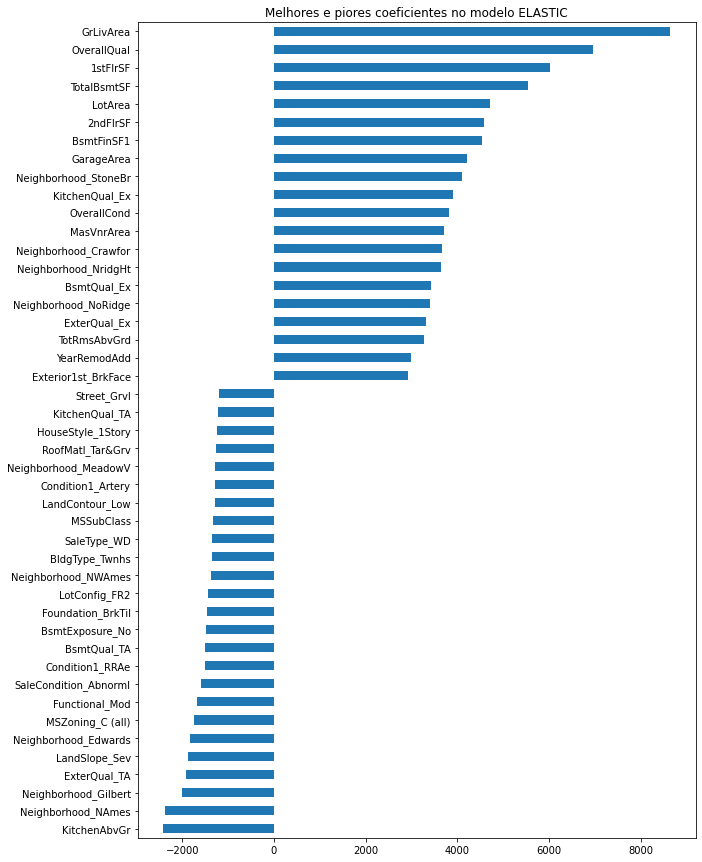

In [34]:
# Os 20 Coeficientes mais relevantes e menos relevantes para o modelo

imp_coef = pd.concat([coef.sort_values().head(25), coef.sort_values().tail(20)])
matplotlib.rcParams['figure.figsize'] = (10.0, 15.0)
imp_coef.plot(kind = "barh")
plt.title("Melhores e piores coeficientes no modelo ELASTIC")
plt.show()

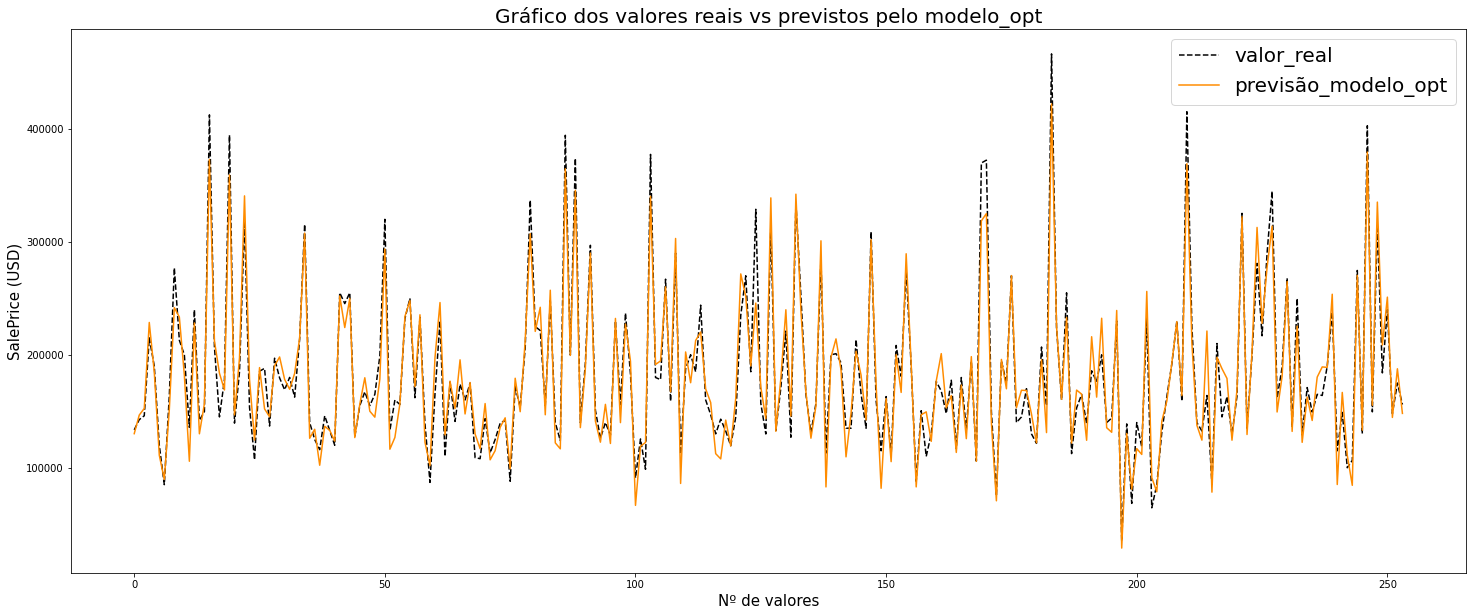

In [35]:
plt.figure(figsize = (25, 10))

plt.plot(y_teste.values, color = 'black', label = 'valor_real', linestyle = '--')
plt.plot(y_pred_opt, color = 'darkorange', label = 'previsão_modelo_opt')


plt.title('Gráfico dos valores reais vs previstos pelo modelo_opt', fontsize = 20)
plt.xlabel('Nº de valores', fontsize = 15)
plt.ylabel('SalePrice (USD)', fontsize = 15)

plt.legend(fontsize = 20)

plt.show()

##### Tabela com os valores reais e a previsão do modelo_opt

In [36]:
data = pd.DataFrame(x_teste, columns = variaveis) 
data['SalePrice_real'] = y_teste.values
data['SalePrice_previsao'] = y_pred_opt
data[['SalePrice_real','SalePrice_previsao']].head().round(1)

,SalePrice_real,SalePrice_previsao
0,133500,130153.4
1,142600,146607.2
2,146000,152501.1
3,215000,228656.9
4,190000,184605.6


#### Análise dos erros

In [37]:
erros = y_teste.values - y_pred_opt
print('Erro médio de %.0f USD' %(np.mean(abs(erros))))

Erro médio de 13585 USD


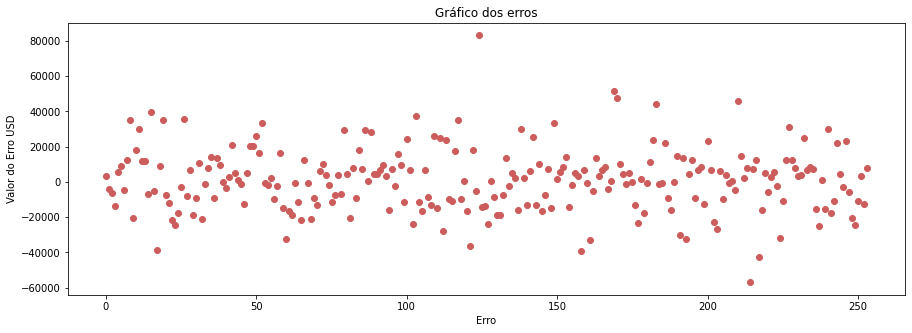

In [38]:
plt.figure(figsize = (15, 5))
plt.scatter(range(len(erros)), erros, color = 'indianred')
plt.title('Gráfico dos erros')
plt.xlabel('Erro')
plt.ylabel('Valor do Erro USD')
plt.show()

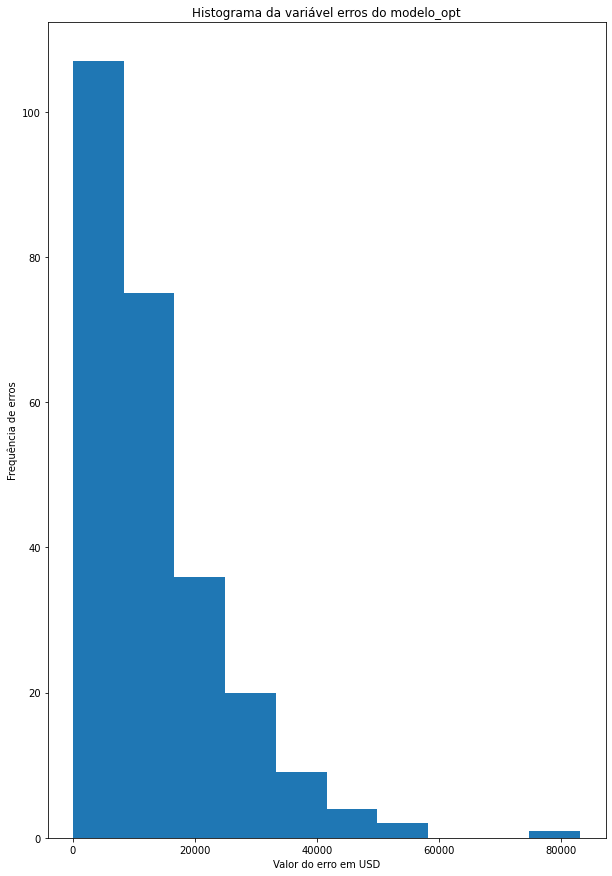

In [40]:
plt.hist(abs(erros))
plt.title('Histograma da variável erros do modelo_opt')
plt.xlabel('Valor do erro em USD')
plt.ylabel('Frequência de erros')
plt.show()

Com base no histograma podemos observar que a maior parte do erros do modelo_opt ocorreu para valores abaixo de cerca de **30000 USD**, ou seja, se nosso modelo for errar, **há grande chances** de ser um erro de **até 30000 USD** na estimativa do preço de venda de uma casa. Esse valor deve ser discutido com a área de negócio para uma total compreensão das consequências de uma estimativa errada.  

## 5) Conclusão 

O modelo final a ser utilizado para predizer o valor da variável alvo 'SalePrice' é um modelo de regressão linear regularizada **ELASTICNET (L1 + L2)**, com parâmetro otimizado **alpha = 0.45**, definido como **modelo_opt**, que obteve os seguintes valores nas métricas definidadas:

    R² = 93.66 %
    MAPE = 7.94 % 
    RMSE = 17977.47 USD 

A etapa de seleção de variáveis e tratamento de variáveis colineares foi suprimida por conta do algoritmo ELASTIC penalizar variáveis colineares e variáveis que não possuem uma forte relação com a variável alvo. 

Na análise de erros verificamos que a maior parte, cerca de 200 valores previstos de um total de 234, possuem um erro de estimativa de até 30000 USD. 
    
Os próximos passos são a entrega do **modelo_opt** , ou seja, utilizar um outro conjunto de dados da área de negócio e fazer as predições. A ideia é fazer o acompanhamento junto da área de negócio para validar as futuras predições do modelo, em outras palavras, se o **modelo_opt** está de fato resolvendo o problema para que foi criado, **prever o valor de venda de imóveis** e trazendo resultados **positivos** para a empresa. 

#### Críticas, elogios, dúvidas e sugestões: 

Autor: Alan Gomes 

E-mail: gomes-alan@hotmail.com 